In [11]:
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.stats import uniform
from astroML.linear_model import NadarayaWatson
from astroML.datasets import generate_mu_z

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

import warnings
warnings.filterwarnings('ignore')

Text(0, 0.5, '$\\mu$')

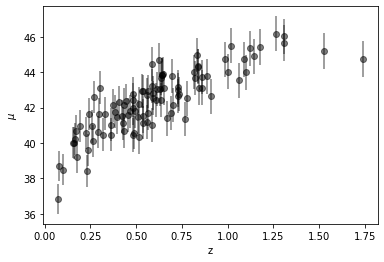

In [12]:
#generating data

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

#plotting data

plt.errorbar(z_sample,mu_sample,dmu,color='black',fmt="o",alpha=0.5);
plt.xlabel("z")
plt.ylabel("$\mu$")

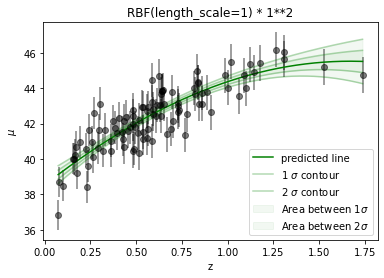

In [111]:
#Trying regression with GPR

#defining points that will be predicted 

xgrid=np.linspace(np.min(z_sample),np.max(z_sample),1000)

#defining the regressor here I use a radial basis function

kernel1 = kernels.RBF()* kernels.ConstantKernel()

#alpha is the variance on the training set

gp = GaussianProcessRegressor(kernel=kernel1, alpha=dmu ** 2)

gp.fit(z_sample[:, None], mu_sample)

f, f_err = gp.predict(xgrid[:, None], return_std=True)
    
#plotting

color='green'

#predicted points

plt.plot(xgrid,f,color=color,label='predicted line') 

#1 sigma contour

plt.plot(xgrid,f+f_err,color=color,alpha=0.3,label='1 $\sigma$ contour') 
plt.plot(xgrid,f-f_err,color=color,alpha=0.3)

#2 sigma contour

plt.plot(xgrid,f+2*f_err,color=color,alpha=0.3,label='2 $\sigma$ contour')
plt.plot(xgrid,f-2*f_err,color=color,alpha=0.3)

#filling the area between the lines

plt.fill_between(xgrid, f+f_err, f-f_err, where=(f-f_err < f+f_err), interpolate=True, color=color, alpha=0.05, label='Area between $1 \sigma$')
plt.fill_between(xgrid, f+2*f_err, f-2*f_err, where=(f-2*f_err < f+2*f_err), interpolate=True, color=color, alpha=0.05, label='Area between $2 \sigma$')

#real data

plt.errorbar(z_sample,mu_sample,dmu,color='black',fmt="o",alpha=0.5);
plt.xlabel("z")
plt.ylabel("$\mu$")

plt.title(str(kernel1))
plt.legend()
plt.show()

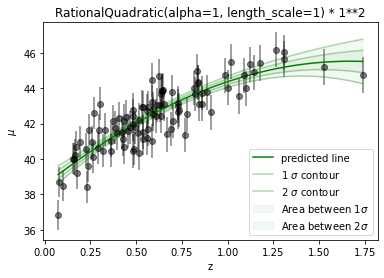

In [104]:
#Trying regression with GPR

#defining points that will be predicted 

xgrid=np.linspace(np.min(z_sample),np.max(z_sample),1000)

#defining the regressor here I use a radial basis function

kernel2 = kernels.RationalQuadratic()* kernels.ConstantKernel()

#alpha is the variance on the training set

gp = GaussianProcessRegressor(kernel=kernel1, alpha=dmu ** 2)

gp.fit(z_sample[:, None], mu_sample)

f, f_err = gp.predict(xgrid[:, None], return_std=True)
    
#plotting

color='green'

#predicted points

plt.plot(xgrid,f,color=color,label='predicted line') 

#1 sigma contour

plt.plot(xgrid,f+f_err,color=color,alpha=0.3,label='1 $\sigma$ contour') 
plt.plot(xgrid,f-f_err,color=color,alpha=0.3)

#2 sigma contour

plt.plot(xgrid,f+2*f_err,color=color,alpha=0.3,label='2 $\sigma$ contour')
plt.plot(xgrid,f-2*f_err,color=color,alpha=0.3)

#filling the area between the lines

plt.fill_between(xgrid, f+f_err, f-f_err, where=(f-f_err < f+f_err), interpolate=True, color=color, alpha=0.05, label='Area between $1 \sigma$')
plt.fill_between(xgrid, f+2*f_err, f-2*f_err, where=(f-2*f_err < f+2*f_err), interpolate=True, color=color, alpha=0.05, label='Area between $2 \sigma$')

#real data

plt.errorbar(z_sample,mu_sample,dmu,color='black',fmt="o",alpha=0.5);
plt.xlabel("z")
plt.ylabel("$\mu$")

plt.title(str(kernel2))
plt.legend()
plt.show()

## Fitting with a cosmological model

In [105]:
# Taking dark energy into account

def integrand_DE(x,matter):
    return 1/np.sqrt(matter*(1+x**3)+(1-matter))


def function_DE(x,A,matter):
    integral = np.array([quad(integrand_DE, 0, x,args=(matter) )[0] for x in x])
    y=5*np.log10((A*(1+x)*integral))
    return y

#neglecting dark energy

def integrand(x):
    return 1/np.sqrt((1+x**3))


def function(x,A):
    integral = np.array([quad(integrand, 0, x )[0] for x in x])
    y=5*np.log10((A*(1+x)*integral))
    return y

In [106]:
#defining the bounds for our parameters, in particular we want lambda_matter > 0

bounds=[(0,0),(np.inf,np.inf)]

#fitting using the model with dark energy

params1, covariance1 = curve_fit(function_DE, z_sample, mu_sample,bounds=bounds,sigma=dmu)

#fitting using the model without dark energy

params2, covariance2 = curve_fit(function, z_sample, mu_sample,sigma=dmu)



In [107]:
#printing parameters

print('paramters from the fit with dark energy: \n \n','(c/H)/10pc: ',params1[0],'\n lambda matter: ',params1[1])
print('\n covariance matrix for the fit with dark energy: \n \n',covariance1)
print('\n paramters from the fit without dark energy: \n \n','(c/H)/10pc: ',params2)
print('\n covariance matrix for the fit without dark energy: \n \n',covariance2)

paramters from the fit with dark energy: 
 
 (c/H)/10pc:  384471727.0305468 
 lambda matter:  0.973129833979846

 covariance matrix for the fit with dark energy: 
 
 [[4.94241843e+14 1.97131359e+07]
 [1.97131359e+07 1.74151307e+00]]

 paramters from the fit without dark energy: 
 
 (c/H)/10pc:  [3.84774667e+08]

 covariance matrix for the fit without dark energy: 
 
 [[2.68774472e+14]]


We see that $\Lambda_{m} \sim 1$. From our data the effect of dark energy is not visible

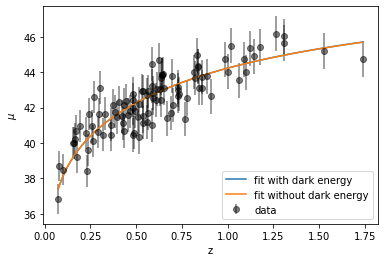

In [92]:
#plotting our fits and comparing

#defining a grid

xgrid=np.linspace(np.min(z_sample),np.max(z_sample),100)

#computing mu from the two fits

mu1=function_DE(xgrid,params1[0],params1[1]) #model with dark energy
mu2=function(xgrid,params2) #model without dark energy

#plots 

plt.plot(xgrid,mu1,label='fit with dark energy')
plt.plot(xgrid,mu2,label='fit without dark energy')

plt.errorbar(z_sample,mu_sample,dmu,color='black',fmt="o",alpha=0.5,label='data');

plt.xlabel("z")
plt.ylabel("$\mu$")

plt.legend()
plt.show()

## Cloning data

In [93]:
#sampling new redhifts from a uniform distribution

new_z=uniform.rvs(0,np.max(z_sample),100)

In [112]:
#cloning using a Radial basis function kernel

gp = GaussianProcessRegressor(kernel=kernel1,alpha=dmu**2)
gp.fit(z_sample[:, None], mu_sample)
new_mu_GPR=gp.predict(new_z[:,None])

In [109]:
#cloning using cosmological fit 

bounds=[(0,0),(np.inf,np.inf)]
params1, covariance1 = curve_fit(function_DE, z_sample, mu_sample,bounds=bounds,sigma=dmu)
new_mu_fit=function_DE(new_z,params1[0],params1[1])

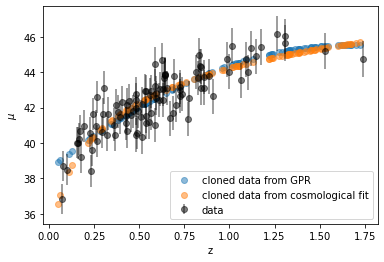

In [113]:
#plotting

plt.scatter(new_z,new_mu_GPR,alpha=0.5,label=('cloned data from GPR'))
plt.scatter(new_z,new_mu_fit,alpha=0.5,label=('cloned data from cosmological fit'))
plt.errorbar(z_sample,mu_sample,dmu,color='black',fmt="o",alpha=0.5,label='data');

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend()